<a href="https://colab.research.google.com/github/Gilf641/EVA4/blob/master/S12_AssignmentSolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Mount Google Drive**

In [1]:
from __future__ import print_function
%matplotlib inline

from google.colab import drive
drive.mount("/content/drive", force_remount=True)


Mounted at /content/drive


**Append Library Path**

In [2]:
import sys
sys.path.append("/content/drive/My Drive/mylib/evaLibrary")
!ls '/content/drive/My Drive/mylib/evaLibrary'

AlbTestTransforms.py   cyclicLR.py     K-MeansClusteringCalculation.xlsx
AlbTrainTransforms.py  DataLoaders.py  LR_Finder.py
albumentations.py      displayData.py  __pycache__
all.py		       execute.py      resNet.py
customNet.py	       Gradcam.py      rohan_library.py


**Load required Libraries**

In [3]:
# import execute
from resNet import ResNet18
import displayData as display
import Gradcam as gdc
import albumentations as alb
import DataLoaders as loader
# import AlbTestTransforms
# import AlbTrainTransforms
import LR_Finder as lrf
import cyclicLR as clr
# import customNet

  pip install torch-lr-finder -v --global-option="amp"


**Download TinyImageNet Zip File**

In [4]:
# !wget http://cs231n.stanford.edu/tiny-imagenet-200.zip
# !unzip -q tiny-imagenet-200.zip && ls tiny-imagenet-200

In [5]:
from torch.utils.data import Dataset, random_split
from PIL import Image
import numpy as np
import torch
import os
import torchvision.transforms as transforms
from tqdm import notebook



# pass the above libs to rohan_library

def TinyImageNetDataSet(splitRatio = 70, test_transforms = None, train_transforms = None):
  classes = extract_classID(path = "tiny-imagenet-200/wnids.txt")
  data = TinyImageNet(classes, defPath="tiny-imagenet-200")
  
  totalLen = len(data)
  print(totalLen) # 110K

  traindata_len = totalLen*splitRatio//100 # 110K * 0.7 = 77K
  testdata_len = totalLen - traindata_len # 110K - 77K = 33K
  
  train, val = random_split(data, [traindata_len, testdata_len]) # split the data according to split ratio
  train_dataset = DatasetFromSubset(train, transform=train_transforms) # Data ready for Loading, passed onto Dataloader func
  test_dataset = DatasetFromSubset(val, transform=test_transforms)

  return train_dataset, test_dataset, classes




class TinyImageNet(Dataset):
    def __init__(self, classes, defPath):
        
        self.classes = classes
        self.defPath = defPath
        self.data = []
        self.target = []
        
        
        wnids = open(f"{defPath}/wnids.txt", "r")

        # Train Data
        trainImagePath = defPath+"/train/"
        for cls in notebook.tqdm(wnids, total = 200):
          cls = cls.strip() # strip spaces out of class names

          indFolderPath = trainImagePath + cls + "/images/"
          
          for i in os.listdir(indFolderPath): # this will list nXXXXXXXX Folders containing 500 Images.
            img = Image.open(indFolderPath + i)
            npimage = np.asarray(img)
                
            if(len(npimage.shape) == 2): 
              npimage = np.repeat(npimage[:, :, np.newaxis], 3, axis=2) # add a new dim using np.newaxis, if it's a 2D
                
            self.data.append(npimage)  # appending image to data 
            self.target.append(self.classes.index(cls)) # appending corresponding class using self.classes


        # Validation Data
        valAnntns = open(f"{defPath}/val/val_annotations.txt", "r")
        for i in notebook.tqdm(valAnntns, total =10000):
          img, cls = i.strip().split("\t")[:2] # this will return image name and class ID. Ex: 'val_1.JPEG', 'n04067472'
          img = Image.open(f"{defPath}/val/images/{img}")
          npimage = np.asarray(img)
          
          if(len(npimage.shape) == 2):  
                npimage = np.repeat(npimage[:, :, np.newaxis], 3, axis=2) # add a new dim using np.newaxis, if it's a 2D
          
          self.data.append(npimage)  
          self.target.append(self.classes.index(cls))


    def __len__(self):
      """
      returns len of the dataset
      """
      return len(self.data)


    def __getitem__(self, idx):
      """
      returns image data & target for the corresponding index
      """
      data = self.data[idx]
      target = self.target[idx]
      img = data     
      return data,target
      
  

class DatasetFromSubset(Dataset):
    """
    Helper Class for transforming the image using albumentations. Usually the data passed is either train or validation
    """
    def __init__(self, subset, transform=None):
        """
        subset: Train or Validation Dataset
        transform : List of Transforms that one wants to apply
        """
        self.subset = subset
        self.transform = transform


    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)



def extract_classID(path = "tiny-imagenet-200/wnids.txt"):
  """
  returns the all the class ID's
  """
  IDFile = open(path, "r")
  classes = []
  for line in IDFile:
    classes.append(line.strip()) # this will append eg: n04099969 
  return classes 



In [6]:
from torchvision import transforms
import albumentations as A
import albumentations.pytorch as AP
import random
import numpy as np

class AlbumentationTransforms:
  """
  Helper class to create test and train transforms using Albumentations
  """
  def __init__(self, transforms_list=[]):
    transforms_list.append(AP.ToTensor()) 
    self.transforms = A.Compose(transforms_list)


  def __call__(self, img):
    img = np.array(img) 
    return self.transforms(image=img)['image']

  

In [7]:

import torch
import torchvision



def convData_To_Dataloader(trainset,testset,seed=1,batch_size=128,num_workers=4,pin_memory=True):
	"""
	Conv DataSet Obj to DataLoader
	"""

	SEED = 1

	# CUDA?
	cuda = torch.cuda.is_available()

	# For reproducibility
	torch.manual_seed(SEED)

	if cuda:
			torch.cuda.manual_seed(SEED)

	dataloader_args = dict(shuffle=True, batch_size=batch_size, num_workers=num_workers, pin_memory=pin_memory) if cuda else dict(shuffle=True, batch_size=64)

	trainloader = torch.utils.data.DataLoader(trainset, **dataloader_args)
	testloader = torch.utils.data.DataLoader(testset, **dataloader_args)


	return  trainloader, testloader



In [8]:
import albumentations as A
import cv2
channel_means = (0.442,0.442,0.442)
channel_stdevs = (0.278, 0.278, 0.278)
train_transform = AlbumentationTransforms([  
                                        A.PadIfNeeded(min_height=70, min_width=70, border_mode=4,  p=1.0),
                                        A.RandomCrop(64, 64,  p=1.0),     
                                        A.Flip(p=0.5),
                                        A.Cutout(num_holes = 2, max_h_size = 8, max_w_size = 8, p = 1.0),
                                        A.Normalize(mean=channel_means, std=channel_stdevs)   
                                       ])
test_transform = AlbumentationTransforms([A.Normalize(mean=channel_means, std=channel_stdevs)])
train_dataset , test_dataset,classes = TinyImageNetDataSet(splitRatio = 70,test_transforms = test_transform,train_transforms = train_transform)


110000


In [9]:
trainLoader, testLoader = convData_To_Dataloader(train_dataset,test_dataset,batch_size=128)

In [10]:

import torch
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential() # if no change in number of channels then self.shortcut is like empty
        if stride != 1 or in_planes != self.expansion*planes: # this is like if there's change in channel number only then it's used I guess
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


# This commenting is for ResNet18
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=200): # block = BasicBlock, num_blocks = [2,2,2,2]
        super(ResNet, self).__init__()
        self.in_planes = 64  # maybe this is the number of kernels at the start

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False) # conv2 with incoming 3 channels
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 8)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])


def ResNet50():
    return ResNet(Bottleneck, [3, 4, 6, 3])


def ResNet101():
    return ResNet(Bottleneck, [3, 4, 23, 3])


def ResNet152():
    return ResNet(Bottleneck, [3, 8, 36, 3])


def test():
    net = ResNet18()
    y = net(torch.randn(1, 3, 32, 32))
    print(y.size())


In [11]:
from torchsummary import summary
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")
model = ResNet18().to(device)
summary(model, input_size=(3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,728
       BatchNorm2d-2           [-1, 64, 64, 64]             128
            Conv2d-3           [-1, 64, 64, 64]          36,864
       BatchNorm2d-4           [-1, 64, 64, 64]             128
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
        BasicBlock-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
           Conv2d-10           [-1, 64, 64, 64]          36,864
      BatchNorm2d-11           [-1, 64, 64, 64]             128
       BasicBlock-12           [-1, 64, 64, 64]               0
           Conv2d-13          [-1, 128, 32, 32]          73,728
      BatchNorm2d-14          [-1, 128,

In [12]:
import torch.optim as optim
import torch.nn as nn
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-2, weight_decay=1e-2)

lr_finder = lrf.LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(trainLoader,start_lr=1e-6, end_lr=100, num_iter=150, step_mode='exp')

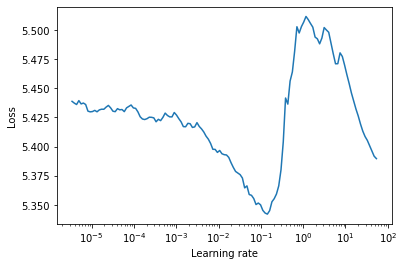

In [13]:
lr_finder.plot()

In [14]:
lr_finder.reset()

In [15]:
# clr.lr_rangetest(device, model, trainLoader, criterion, 0.001, 0.01, 10)

In [16]:
from tqdm import tqdm
import numpy as np
import torch.nn.functional as F
import torch


class Test_Train():
  def __init__(self, model, device, optimizer, criterion, scheduler=True ):


    self.model = model
    self.device = device
    self.optimizer = optimizer
    self.criterion = criterion
    self.scheduler = scheduler

# # This is to hold all the values and plot some graphs to extract few good insights.
    self.train_losses = []
    self.test_losses = []
    self.train_acc = []
    self.test_acc = []
    self.train_epoch_end = []
    self.test_loss_min = np.inf # setting it to infinity(max value)
    # when the test loss becomes min I will save the particular model


  def train(self, trainloader, epoch):
    self.model.train()    # prepare model for training
    pbar = tqdm(trainloader)
    correct = 0
    processed = 0
    loss = 0
    for batch_idx, (data, target) in enumerate(pbar): # passing on data & target values to device
      data, target = data.to(self.device), target.to(self.device)
      self.optimizer.zero_grad()    # clear the gradients of all optimized variables

      # Predict
      y_pred = self.model(data)   # forward pass

      # Calculate loss
      loss = self.criterion(y_pred, target)

      # #Implementing L1 Regularization
      # if L1lambda:
      #   with torch.enable_grad():
      #     l1_loss = 0.
      #     for param in self.model.parameters():
      #       l1_loss += torch.sum(param.abs())
      #     loss = c_loss +  (L1lambda * l1_loss)



      # Backpropagation
      loss.backward()   # backward pass: compute gradient of the loss with respect to model parameters
      self.optimizer.step()   # perform a single optimization step (parameter update)
      # if self.scheduler:
      #   scheduler.step(loss)


      # Update pbar-tqdm
      pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
      correct += pred.eq(target.view_as(pred)).sum().item()
      processed += len(data)

      pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    self.train_acc.append(100*correct/processed)
    
    self.train_epoch_end.append(self.train_acc[-1])
    self.train_losses.append(loss)


  def test(self, testloader, filename, correct_samples, correctLabels, incorrect_samples):
      self.model.eval()  # prep model for evaluation
      test_loss = 0
      correct = 0

      with torch.no_grad(): # setting gradients back to zero
          for data, target in testloader:

            img_batch = data # this is done to store data
            data, target = data.to(self.device), target.to(self.device)

            # forward pass: compute predicted outputs by passing inputs to the model
            output = self.model(data)

            # sum up batch loss
            # test_loss += F.nll_loss(output, target, reduction='sum').item()
            test_loss = self.criterion(output, target).item()


            # get the index of the max log-probability
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

            # storing the entire result data as binary
            result = pred.eq(target.view_as(pred))
            # scheduler.step()

            # This is to extract incorrect samples/misclassified images
            if len(incorrect_samples) < 25:
              for i in range(0, testloader.batch_size):
                if not list(result)[i]:
                  incorrect_samples.append({'prediction': list(pred)[i], 'label': list(target.view_as(pred))[i],'image': img_batch[i]})


            # this is to extract correct samples/classified images
            if len(correct_samples) < 25:
              for i in range(0, testloader.batch_size):
                if list(result)[i]:
                  correct_samples.append({'prediction': list(pred)[i], 'label': list(target.view_as(pred))[i],'image': img_batch[i]})
                  correctLabels.append(list(target.view_as(pred))[i]) # this is for gradcam




      # save model if validation loss has decreased
      if test_loss <= self.test_loss_min:
          print('Validation loss has  decreased ({:.4f} --> {:.4f}).  Saving model ...'.format(self.test_loss_min,test_loss ))
          torch.save(self.model.state_dict(), filename)
          self.test_loss_min = test_loss


      print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
          test_loss, correct, len(testloader.dataset),
          100. * correct / len(testloader.dataset)))


      self.test_acc.append(100. * correct / len(testloader.dataset))
      self.test_losses.append(test_loss)



def cross_entropy_loss():
    """Returns:
        Cross entroy loss function
    """
    return torch.nn.CrossEntropyLoss()

def model_summary(model, input_size=(3,32,32)):
  """
  Returns Summary of the model passed in as model
  """
  return summary(model, input_size)



In [ ]:
incorrectSamples = []
correctSamples = []
correctLabels = []
learningRates = []
model = ResNet18().to(device)
EPOCHS = 50
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.001, momentum=0.95, weight_decay = 1e-2, nesterov = True) 
# scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr = 0.02, total_steps=19000, epochs = 30, steps_per_epoch=len(trainLoader),
#                                                 pct_start=1/3, anneal_strategy='linear', cycle_momentum=True, 
#                                                 base_momentum=0.85, max_momentum=0.95, div_factor=10, final_div_factor=1)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=3, threshold=0.001)

model1 = Test_Train(model, device, optimizer, criterion, scheduler=True)



for epoch in range(1, EPOCHS+1):
  print('EPOCH: ',epoch)
  model1.train(trainLoader, epoch)
  model1.test(testLoader, 'model1.pt', correctSamples, correctLabels, incorrectSamples)
  scheduler.step(model1.test_losses[-1])
  for param_group in optimizer.param_groups:
    print('Learning Rate = {a} for EPOCH {e}'.format(a = round(param_group['lr'],5), e=epoch+1))
    learningRates.append(param_group['lr'])
  

  0%|          | 0/602 [00:00<?, ?it/s]

EPOCH:  1


Loss=4.350662708282471 Batch_id=601 Accuracy=5.89: 100%|██████████| 602/602 [04:37<00:00,  2.17it/s]
  0%|          | 0/602 [00:00<?, ?it/s]

Validation loss has  decreased (inf --> 4.2484).  Saving model ...

Test set: Average loss: 4.2484, Accuracy: 3148/33000 (9.54%)

Learning Rate = 0.001 for EPOCH 2
EPOCH:  2


Loss=4.011900424957275 Batch_id=601 Accuracy=12.94: 100%|██████████| 602/602 [04:37<00:00,  2.17it/s]
  0%|          | 0/602 [00:00<?, ?it/s]

Validation loss has  decreased (4.2484 --> 4.1964).  Saving model ...

Test set: Average loss: 4.1964, Accuracy: 4620/33000 (14.00%)

Learning Rate = 0.001 for EPOCH 3
EPOCH:  3


Loss=3.8958969116210938 Batch_id=601 Accuracy=17.32: 100%|██████████| 602/602 [04:37<00:00,  2.17it/s]
  0%|          | 0/602 [00:00<?, ?it/s]

Validation loss has  decreased (4.1964 --> 3.7596).  Saving model ...

Test set: Average loss: 3.7596, Accuracy: 5781/33000 (17.52%)

Learning Rate = 0.001 for EPOCH 4
EPOCH:  4


Loss=3.655005931854248 Batch_id=601 Accuracy=20.79: 100%|██████████| 602/602 [04:37<00:00,  2.17it/s]
  0%|          | 0/602 [00:00<?, ?it/s]

Validation loss has  decreased (3.7596 --> 3.5017).  Saving model ...

Test set: Average loss: 3.5017, Accuracy: 6844/33000 (20.74%)

Learning Rate = 0.001 for EPOCH 5
EPOCH:  5


Loss=3.020206928253174 Batch_id=601 Accuracy=23.51: 100%|██████████| 602/602 [04:38<00:00,  2.17it/s]
  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 3.6182, Accuracy: 7140/33000 (21.64%)

Learning Rate = 0.001 for EPOCH 6
EPOCH:  6


Loss=3.2671468257904053 Batch_id=601 Accuracy=25.71: 100%|██████████| 602/602 [04:37<00:00,  2.17it/s]
  0%|          | 0/602 [00:00<?, ?it/s]

Validation loss has  decreased (3.5017 --> 3.4185).  Saving model ...

Test set: Average loss: 3.4185, Accuracy: 7821/33000 (23.70%)

Learning Rate = 0.001 for EPOCH 7
EPOCH:  7


Loss=3.352687358856201 Batch_id=601 Accuracy=27.44: 100%|██████████| 602/602 [04:37<00:00,  2.17it/s]
  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 3.4349, Accuracy: 7935/33000 (24.05%)

Learning Rate = 0.001 for EPOCH 8
EPOCH:  8


Loss=2.8716578483581543 Batch_id=601 Accuracy=29.12: 100%|██████████| 602/602 [04:37<00:00,  2.17it/s]
  0%|          | 0/602 [00:00<?, ?it/s]

Validation loss has  decreased (3.4185 --> 3.1480).  Saving model ...

Test set: Average loss: 3.1480, Accuracy: 9406/33000 (28.50%)

Learning Rate = 0.001 for EPOCH 9
EPOCH:  9


Loss=2.9544003009796143 Batch_id=601 Accuracy=30.23: 100%|██████████| 602/602 [04:37<00:00,  2.17it/s]
  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 3.2797, Accuracy: 9372/33000 (28.40%)

Learning Rate = 0.001 for EPOCH 10
EPOCH:  10


Loss=3.046381950378418 Batch_id=601 Accuracy=31.36: 100%|██████████| 602/602 [04:37<00:00,  2.17it/s]
  0%|          | 0/602 [00:00<?, ?it/s]

Validation loss has  decreased (3.1480 --> 3.1217).  Saving model ...

Test set: Average loss: 3.1217, Accuracy: 8735/33000 (26.47%)

Learning Rate = 0.001 for EPOCH 11
EPOCH:  11


Loss=2.841986656188965 Batch_id=601 Accuracy=32.71: 100%|██████████| 602/602 [04:37<00:00,  2.17it/s]
  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 3.1543, Accuracy: 10172/33000 (30.82%)

Learning Rate = 0.001 for EPOCH 12
EPOCH:  12


Loss=2.847827672958374 Batch_id=601 Accuracy=33.76: 100%|██████████| 602/602 [04:37<00:00,  2.17it/s]
  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 3.2229, Accuracy: 9942/33000 (30.13%)

Learning Rate = 0.001 for EPOCH 13
EPOCH:  13


Loss=2.921747922897339 Batch_id=601 Accuracy=34.80: 100%|██████████| 602/602 [04:37<00:00,  2.17it/s]
  0%|          | 0/602 [00:00<?, ?it/s]

Validation loss has  decreased (3.1217 --> 2.6982).  Saving model ...

Test set: Average loss: 2.6982, Accuracy: 10045/33000 (30.44%)

Learning Rate = 0.001 for EPOCH 14
EPOCH:  14


Loss=2.8829691410064697 Batch_id=601 Accuracy=35.75: 100%|██████████| 602/602 [04:37<00:00,  2.17it/s]
  0%|          | 0/602 [00:00<?, ?it/s]

Validation loss has  decreased (2.6982 --> 2.5537).  Saving model ...

Test set: Average loss: 2.5537, Accuracy: 10475/33000 (31.74%)

Learning Rate = 0.001 for EPOCH 15
EPOCH:  15


Loss=2.9338839054107666 Batch_id=601 Accuracy=36.34: 100%|██████████| 602/602 [04:37<00:00,  2.17it/s]
  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 2.8865, Accuracy: 11038/33000 (33.45%)

Learning Rate = 0.001 for EPOCH 16
EPOCH:  16


Loss=2.4499940872192383 Batch_id=601 Accuracy=37.09: 100%|██████████| 602/602 [04:37<00:00,  2.17it/s]
  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 3.0435, Accuracy: 10231/33000 (31.00%)

Learning Rate = 0.001 for EPOCH 17
EPOCH:  17


Loss=3.0032663345336914 Batch_id=601 Accuracy=37.79: 100%|██████████| 602/602 [04:37<00:00,  2.17it/s]
  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 2.8657, Accuracy: 11519/33000 (34.91%)

Learning Rate = 0.001 for EPOCH 18
EPOCH:  18


Loss=2.5953280925750732 Batch_id=601 Accuracy=38.58: 100%|██████████| 602/602 [04:37<00:00,  2.17it/s]
  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 2.8109, Accuracy: 11198/33000 (33.93%)

Learning Rate = 0.0002 for EPOCH 19
EPOCH:  19


Loss=2.331157684326172 Batch_id=601 Accuracy=44.63: 100%|██████████| 602/602 [04:37<00:00,  2.17it/s]
  0%|          | 0/602 [00:00<?, ?it/s]

Validation loss has  decreased (2.5537 --> 2.3994).  Saving model ...

Test set: Average loss: 2.3994, Accuracy: 14223/33000 (43.10%)

Learning Rate = 0.0002 for EPOCH 20
EPOCH:  20


Loss=2.5678274631500244 Batch_id=601 Accuracy=46.76: 100%|██████████| 602/602 [04:37<00:00,  2.17it/s]
  0%|          | 0/602 [00:00<?, ?it/s]

Validation loss has  decreased (2.3994 --> 2.2483).  Saving model ...

Test set: Average loss: 2.2483, Accuracy: 14549/33000 (44.09%)

Learning Rate = 0.0002 for EPOCH 21
EPOCH:  21


Loss=2.4395737648010254 Batch_id=601 Accuracy=47.65: 100%|██████████| 602/602 [04:37<00:00,  2.17it/s]
  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 2.4299, Accuracy: 14463/33000 (43.83%)

Learning Rate = 0.0002 for EPOCH 22
EPOCH:  22


Loss=2.5023844242095947 Batch_id=601 Accuracy=48.28: 100%|██████████| 602/602 [04:37<00:00,  2.17it/s]
  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 2.2900, Accuracy: 14620/33000 (44.30%)

Learning Rate = 0.0002 for EPOCH 23
EPOCH:  23


Loss=2.275973320007324 Batch_id=601 Accuracy=48.80: 100%|██████████| 602/602 [04:37<00:00,  2.17it/s]
  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 2.3384, Accuracy: 14946/33000 (45.29%)

Learning Rate = 0.0002 for EPOCH 24
EPOCH:  24


Loss=2.1350691318511963 Batch_id=601 Accuracy=49.52: 100%|██████████| 602/602 [04:37<00:00,  2.17it/s]
  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 2.3284, Accuracy: 14717/33000 (44.60%)

Learning Rate = 4e-05 for EPOCH 25
EPOCH:  25


Loss=2.246978521347046 Batch_id=601 Accuracy=52.61: 100%|██████████| 602/602 [04:37<00:00,  2.17it/s]
  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 2.4097, Accuracy: 15749/33000 (47.72%)

Learning Rate = 4e-05 for EPOCH 26
EPOCH:  26


Loss=2.2143194675445557 Batch_id=601 Accuracy=53.70: 100%|██████████| 602/602 [04:37<00:00,  2.17it/s]
  0%|          | 0/602 [00:00<?, ?it/s]

Validation loss has  decreased (2.2483 --> 1.9513).  Saving model ...

Test set: Average loss: 1.9513, Accuracy: 15785/33000 (47.83%)

Learning Rate = 4e-05 for EPOCH 27
EPOCH:  27


Loss=1.9244052171707153 Batch_id=601 Accuracy=53.99: 100%|██████████| 602/602 [04:37<00:00,  2.17it/s]
  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 2.0341, Accuracy: 15936/33000 (48.29%)

Learning Rate = 4e-05 for EPOCH 28
EPOCH:  28


Loss=2.0404531955718994 Batch_id=601 Accuracy=54.32: 100%|██████████| 602/602 [04:37<00:00,  2.17it/s]
  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 2.3506, Accuracy: 15957/33000 (48.35%)

Learning Rate = 4e-05 for EPOCH 29
EPOCH:  29


Loss=2.010352611541748 Batch_id=601 Accuracy=54.53: 100%|██████████| 602/602 [04:37<00:00,  2.17it/s]
  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 2.1865, Accuracy: 15956/33000 (48.35%)

Learning Rate = 4e-05 for EPOCH 30
EPOCH:  30


Loss=2.2878904342651367 Batch_id=601 Accuracy=54.87: 100%|██████████| 602/602 [04:37<00:00,  2.17it/s]
  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 2.1898, Accuracy: 15965/33000 (48.38%)

Learning Rate = 1e-05 for EPOCH 31
EPOCH:  31


Loss=1.9710890054702759 Batch_id=601 Accuracy=56.06: 100%|██████████| 602/602 [04:37<00:00,  2.17it/s]
  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 2.1060, Accuracy: 16165/33000 (48.98%)

Learning Rate = 1e-05 for EPOCH 32
EPOCH:  32


Loss=2.124695062637329 Batch_id=601 Accuracy=56.10: 100%|██████████| 602/602 [04:37<00:00,  2.17it/s]
  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 2.5592, Accuracy: 16159/33000 (48.97%)

Learning Rate = 1e-05 for EPOCH 33
EPOCH:  33


Loss=2.2287983894348145 Batch_id=601 Accuracy=56.51: 100%|██████████| 602/602 [04:37<00:00,  2.17it/s]
  0%|          | 0/602 [00:00<?, ?it/s]

Validation loss has  decreased (1.9513 --> 1.9254).  Saving model ...

Test set: Average loss: 1.9254, Accuracy: 16184/33000 (49.04%)

Learning Rate = 1e-05 for EPOCH 34
EPOCH:  34


Loss=2.1799206733703613 Batch_id=601 Accuracy=56.39: 100%|██████████| 602/602 [04:37<00:00,  2.17it/s]
  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 1.9640, Accuracy: 16204/33000 (49.10%)

Learning Rate = 1e-05 for EPOCH 35
EPOCH:  35


Loss=2.0608184337615967 Batch_id=601 Accuracy=56.43: 100%|██████████| 602/602 [04:37<00:00,  2.17it/s]
  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 2.7590, Accuracy: 16188/33000 (49.05%)

Learning Rate = 1e-05 for EPOCH 36
EPOCH:  36


Loss=2.18464994430542 Batch_id=601 Accuracy=56.50: 100%|██████████| 602/602 [04:37<00:00,  2.17it/s]
  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 2.1746, Accuracy: 16150/33000 (48.94%)

Learning Rate = 1e-05 for EPOCH 37
EPOCH:  37


Loss=2.0053701400756836 Batch_id=601 Accuracy=56.56: 100%|██████████| 602/602 [04:37<00:00,  2.17it/s]
  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 2.1733, Accuracy: 16231/33000 (49.18%)

Learning Rate = 0.0 for EPOCH 38
EPOCH:  38


Loss=1.9915087223052979 Batch_id=601 Accuracy=56.97: 100%|██████████| 602/602 [04:37<00:00,  2.17it/s]
  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 2.4592, Accuracy: 16257/33000 (49.26%)

Learning Rate = 0.0 for EPOCH 39
EPOCH:  39


Loss=2.5879509449005127 Batch_id=601 Accuracy=56.92: 100%|██████████| 602/602 [04:37<00:00,  2.17it/s]
  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 2.2702, Accuracy: 16211/33000 (49.12%)

Learning Rate = 0.0 for EPOCH 40
EPOCH:  40


Loss=2.202385663986206 Batch_id=601 Accuracy=56.92: 100%|██████████| 602/602 [04:37<00:00,  2.17it/s]
  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 2.1965, Accuracy: 16204/33000 (49.10%)

Learning Rate = 0.0 for EPOCH 41
EPOCH:  41


Loss=2.079322338104248 Batch_id=74 Accuracy=56.60:  12%|█▏        | 75/602 [00:34<04:01,  2.18it/s]

In [ ]:
# a = []
# while(1):
#   a.append("b")

**Displaying Model Curves**

In [ ]:
accuracyElements = [(model1.test_acc,"Validation Accuracy"),(model1.train_epoch_end,"Train Accuracy")]
lossElements = [(model1.test_losses,"Validation Loss"),(model1.train_losses,"Train Loss")]

for i in range(1):
  display.plot_curve(lossElements,'Training & Validation Loss of ResNet18 on TinyImageNet', y_label='Loss')
  display.plot_curve(accuracyElements,'Training & Validation Accuracy of ResNet18 on TinyImageNet')